# Deep Learning Project 1 - MLPs and CNN for image classification
> **MSc in Data Science, AUEB**<br />
> Giogiakas Sotirios ( *p3352204* ) <br />
> Sakkis Panagiotis ( *p3352222* )


## CIFAR-10 Dataset

Imports

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from tensorflow.keras.datasets import cifar10
from keras.models import Model

print(tf.__version__)

2.15.0


In [4]:
random_seed = 42
random.seed(random_seed)
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

Helper Functions

In [5]:
def plot_image(i, predictions, true_labels, img, class_names):
    predictions_array, true_label, img = predictions[i], true_labels[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

In [6]:
def plot_value_array(i, predictions, true_labels, class_names, show_xticks=False):
    predictions_array, true_label = predictions[i], true_labels[i]
    plt.grid(False)
    plt.xticks([])
    if show_xticks:
        plt.xticks(range(10), class_names, rotation='vertical')
    else:
        plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

In [7]:
def plot_training_curves(training_history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(training_history.history['accuracy'])
    plt.plot(training_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'])
    plt.plot(training_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()

### Import CIFAR-10 dataset

In [8]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names =['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

170498071/170498071 [==============================] - 13s 0us/step


Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


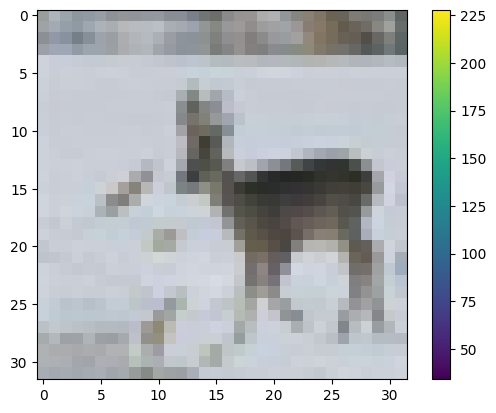

Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [9]:
# Print the shape of the datasets
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)


# Visualize the first image from the training set
plt.figure()
plt.imshow(x_train[20])
plt.colorbar()
plt.grid(False)
plt.show()

# Print the shape of the datasets
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

In [10]:
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = y_train.flatten()
y_test = y_test.flatten()

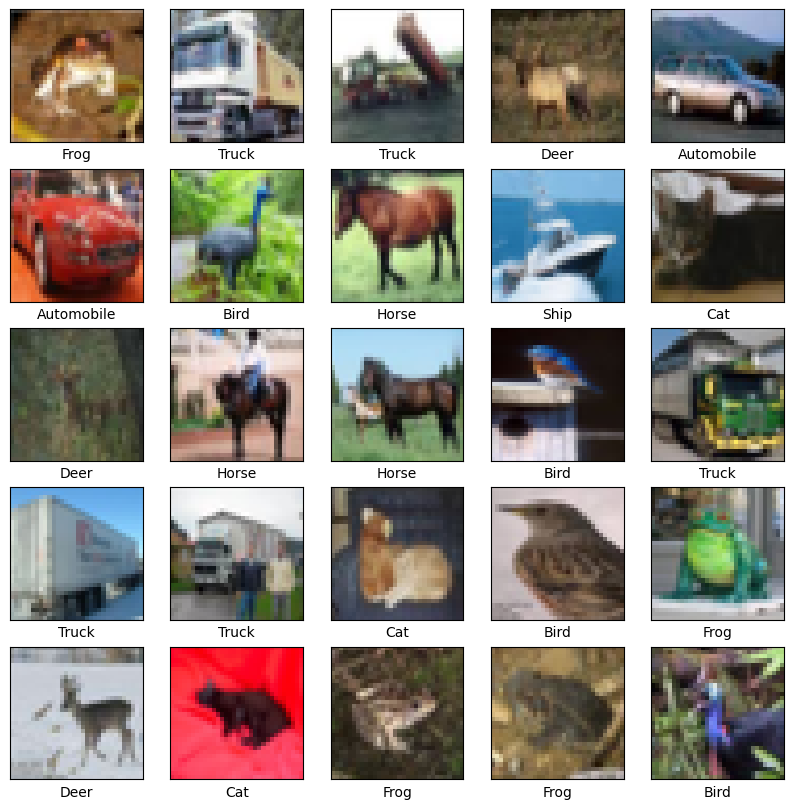

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

plt.show()

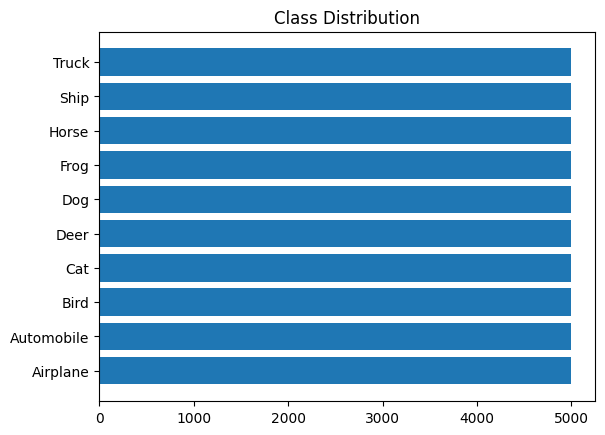

In [12]:
counts = np.bincount(y_train)

uniques = np.unique(y_train)

plt.barh(uniques, counts, align='center')
plt.yticks(uniques, class_names)
plt.title('Class Distribution')
plt.show()

### MLP

In [13]:
def build_model_cifar(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())

    layer_index = 0
    for i in range(hp.Int(name='num_layers',min_value=1,max_value=2)):
        if layer_index == 0:
            model.add(
                tf.keras.layers.Dense(
                    units=hp.Int('units', min_value=512, max_value=4096, step=512),
                    kernel_initializer='glorot_uniform',
                    activation='relu')
                    )
            model.add(tf.keras.layers.Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2])))
        else:
            model.add(
                tf.keras.layers.Dense(
                    units=hp.Int(name='hidden_units_'+str(i),min_value=64 ,max_value=512, step=64),
                    kernel_initializer='glorot_uniform',
                    activation='relu')
            )
            model.add(tf.keras.layers.Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2])))

        layer_index += 1

    # Add last layer that produces the logits
    model.add(tf.keras.layers.Dense(len(class_names),  activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.001, 0.0001, or 0.00001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5, 2e-5])

    # Now compile your model with previous param
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

In [14]:
tuner = kt.Hyperband(build_model_cifar,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     overwrite=True,
                     seed=42,
                     project_name='deep_lr_cifar')

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [16]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 30 Complete [00h 00m 49s]
val_accuracy: 0.484499990940094

Best val_accuracy So Far: 0.4964999854564667
Total elapsed time: 00h 13m 48s


In [17]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'num_layers': 2,
 'units': 1024,
 'dropout_layer_0': 0.1,
 'learning_rate': 0.0001,
 'hidden_units_1': 512,
 'dropout_layer_1': 0.2,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0014'}

In [18]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
1250/1250 [==============================] - 6s 4ms/step - loss: 1.8902 - accuracy: 0.3179 - val_loss: 1.7535 - val_accuracy: 0.3776
Epoch 2/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7058 - accuracy: 0.3864 - val_loss: 1.6694 - val_accuracy: 0.4061
Epoch 3/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6260 - accuracy: 0.4205 - val_loss: 1.5984 - val_accuracy: 0.4343
Epoch 4/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5725 - accuracy: 0.4410 - val_loss: 1.5700 - val_accuracy: 0.4447
Epoch 5/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5241 - accuracy: 0.4572 - val_loss: 1.5255 - val_accuracy: 0.4650
Epoch 6/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4858 - accuracy: 0.4681 - val_loss: 1.5361 - val_accuracy: 0.4506
Epoch 7/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4553 - accuracy: 0.4824 - val_loss: 1.4775 - val_accuracy:

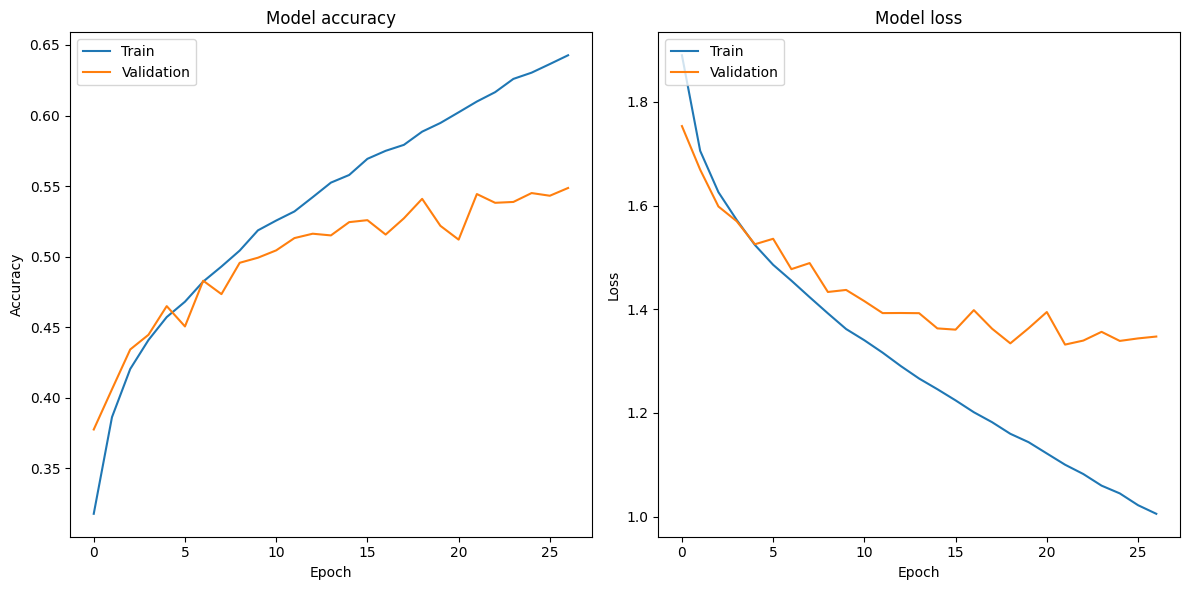

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [20]:
model.save("cifar_mlp_best_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# test the model on testing data
eval_result = model.evaluate(x_test, y_test, verbose = 1)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 1.3271 - accuracy: 0.5480
[test loss, test accuracy]: [1.3271337747573853, 0.5479999780654907]


In [22]:
# predictions = np.argmax(model.predict(X_test), -1)
predictions = model.predict(x_test)
print(classification_report(y_test, np.argmax(predictions,-1), target_names=class_names))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    Airplane       0.64      0.58      0.61      1000
  Automobile       0.71      0.63      0.67      1000
        Bird       0.45      0.40      0.43      1000
         Cat       0.37      0.36      0.36      1000
        Deer       0.41      0.53      0.46      1000
         Dog       0.46      0.43      0.45      1000
        Frog       0.56      0.66      0.61      1000
       Horse       0.63      0.60      0.61      1000
        Ship       0.63      0.73      0.68      1000
       Truck       0.67      0.56      0.61      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



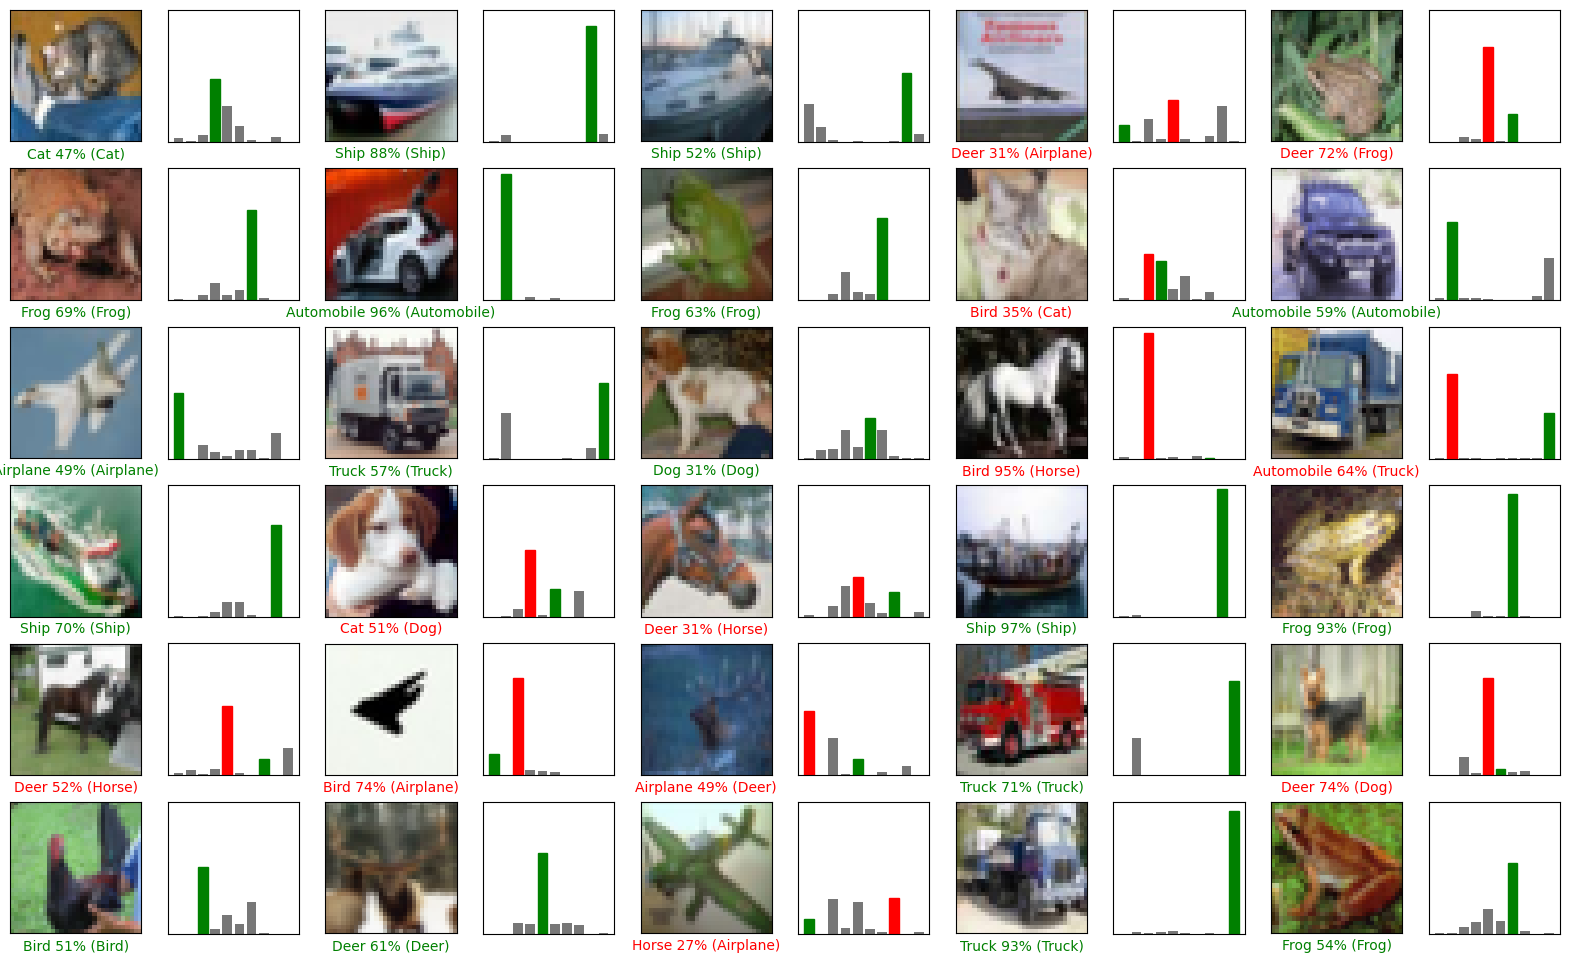

In [23]:
# verification of several images

num_rows=6
num_cols=5
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))

show_x_ticks = False

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)

    plot_image(i, predictions, y_test, x_test,class_names)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, y_test, show_x_ticks)

plt.show()



### CNN

In [24]:
def build_cnn_model_cifar(hp):

    pooling_type = hp.Choice(f'pooling_type', values = ['max','avg'])
    filters_1st = hp.Int(f'conv_0_filter', min_value=16, max_value=64, step=16)
    kernel_1st = hp.Choice(f'conv_0_kernel_size', values = [3,5])
    dropout_rate = hp.Choice(name='dropout_layer_rate',values=[0.1, 0.2])
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    # create model object
    model = tf.keras.Sequential()
    #adding convolutional layer
    model.add(tf.keras.layers.Conv2D(
        #adding filter
        filters=filters_1st,
        # adding filter size or kernel size
        kernel_size=kernel_1st,
        strides=(1, 1),
        padding='same',
        #activation function
        activation='relu'
    ))
    model.add(tf.keras.layers.Conv2D(
        #adding filter
        filters=filters_1st,
        # adding filter size or kernel size
        kernel_size=kernel_1st,
        strides=(1, 1),
        padding='same',
        #activation function
        activation='relu'
    ))

    model.add(
        tf.keras.layers.BatchNormalization()
    )
    if pooling_type == 'max':
        # add poolling layer
        model.add(tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same'
        ))
    elif pooling_type == 'avg':
        # add poolling layer
        model.add(tf.keras.layers.AveragePooling2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same'
        ))

    for i in range(hp.Int(name='conv_layers',min_value=1,max_value=2)):
        f = hp.Int(f'conv_{str(i+1)}_filter', min_value=16, max_value=64, step=16)
        k = hp.Choice(f'conv_{str(i+1)}_kernel', values = [3,5])
        #adding convolutional layer
        model.add(tf.keras.layers.Conv2D(
            #adding filter
            filters=f,
            # adding filter size or kernel size
            kernel_size=k,
            strides=(1, 1),
            padding='same',
            #activation function
            activation='relu'
        ))
        model.add(tf.keras.layers.Conv2D(
            #adding filter
            filters=f,
            # adding filter size or kernel size
            kernel_size=k,
            strides=(1, 1),
            padding='same',
            #activation function
            activation='relu'
        ))

        model.add(
            tf.keras.layers.BatchNormalization()
        )
        if pooling_type == 'max':
            # add poolling layer
            model.add(tf.keras.layers.MaxPooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                padding='same'
            ))
        elif pooling_type == 'avg':
            # add poolling layer
            model.add(tf.keras.layers.AveragePooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                padding='same'
            ))


    model.add(tf.keras.layers.Dropout(
        rate=dropout_rate
    ))

    # adding flatten layer
    model.add(tf.keras.layers.Flatten())
    # adding dense layer
    model.add(tf.keras.layers.Dense(
        units=hp.Choice('units', values=[1024, 2048, 4096]),
            kernel_initializer='glorot_uniform',
            activation='relu'
    ))

    model.add(tf.keras.layers.Dropout(
        rate=dropout_rate
    ))

    # output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    #compilation of model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [25]:
tuner = kt.Hyperband(build_cnn_model_cifar,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     overwrite=True,
                     seed=42,
                     project_name='deep_cifar_2')

In [26]:
reduce_lr_plateau = ReduceLROnPlateau(
        monitor = 'val_accuracy',
        factor = 0.1,
        patience = 2,
        min_delta = 0.0001,
        cooldown = 0,
        min_lr = 0
)

In [27]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [29]:
tuner.search(x_train, y_train, batch_size=128,
             epochs=50, validation_split=0.2,
             callbacks=[early_stopping])


Trial 30 Complete [00h 02m 11s]
val_accuracy: 0.7365999817848206

Best val_accuracy So Far: 0.7633000016212463
Total elapsed time: 00h 31m 47s


In [30]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'pooling_type': 'avg',
 'conv_0_filter': 16,
 'conv_0_kernel_size': 3,
 'dropout_layer_rate': 0.1,
 'learning_rate': 0.001,
 'conv_layers': 2,
 'conv_1_filter': 48,
 'conv_1_kernel': 5,
 'units': 4096,
 'conv_2_filter': 16,
 'conv_2_kernel': 5,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [31]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
cnn_model = tuner.hypermodel.build(best_hps)
#cnn_model.summary()

In [32]:
cnn_history = cnn_model.fit(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
1250/1250 [==============================] - 10s 7ms/step - loss: 1.3682 - accuracy: 0.5081 - val_loss: 1.4026 - val_accuracy: 0.5262
Epoch 2/50
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9553 - accuracy: 0.6633 - val_loss: 0.9548 - val_accuracy: 0.6604
Epoch 3/50
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8016 - accuracy: 0.7185 - val_loss: 0.8926 - val_accuracy: 0.6921
Epoch 4/50
1250/1250 [==============================] - 7s 6ms/step - loss: 0.6965 - accuracy: 0.7552 - val_loss: 0.9144 - val_accuracy: 0.6956
Epoch 5/50
1250/1250 [==============================] - 8s 7ms/step - loss: 0.6120 - accuracy: 0.7841 - val_loss: 0.7544 - val_accuracy: 0.7421
Epoch 6/50
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5334 - accuracy: 0.8125 - val_loss: 0.7865 - val_accuracy: 0.7406
Epoch 7/50
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4652 - accuracy: 0.8373 - val_loss: 0.6953 - val_accuracy

In [33]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_2 (Bat  (None, 32, 32, 16)        64        
 chNormalization)                                                
                                                                 
 average_pooling2d (Average  (None, 16, 16, 16)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 48)        19248     
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 48)       

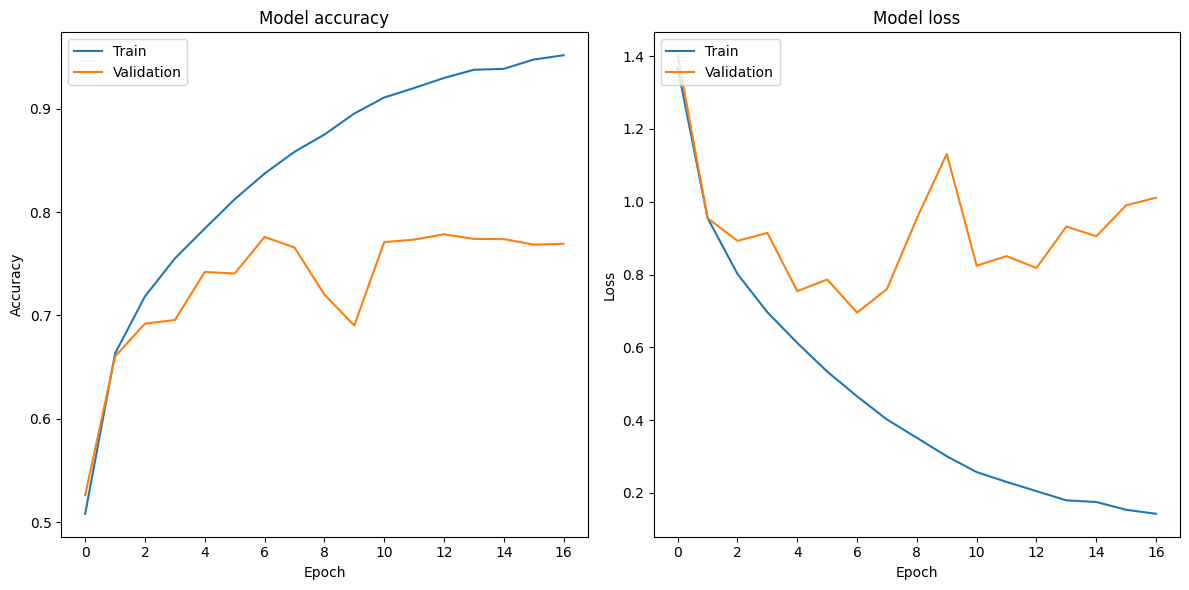

In [34]:
plot_training_curves(cnn_history)

In [35]:
cnn_model.save("cifar_cnn_best_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
# test the model on testing data
eval_result = cnn_model.evaluate(x_test, y_test, verbose = 1)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 4ms/step - loss: 0.5821 - accuracy: 0.8249
[test loss, test accuracy]: [0.5820972323417664, 0.8248999714851379]


In [37]:
# predictions = np.argmax(model.predict(X_test), -1)
predictions = cnn_model.predict(x_test)
print(classification_report(y_test, np.argmax(predictions,-1), target_names=class_names))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    Airplane       0.75      0.86      0.80      1000
  Automobile       0.88      0.91      0.89      1000
        Bird       0.76      0.62      0.68      1000
         Cat       0.55      0.57      0.56      1000
        Deer       0.77      0.68      0.72      1000
         Dog       0.66      0.61      0.63      1000
        Frog       0.82      0.83      0.82      1000
       Horse       0.75      0.86      0.80      1000
        Ship       0.89      0.86      0.88      1000
       Truck       0.83      0.86      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.76     10000
weighted avg       0.77      0.77      0.76     10000



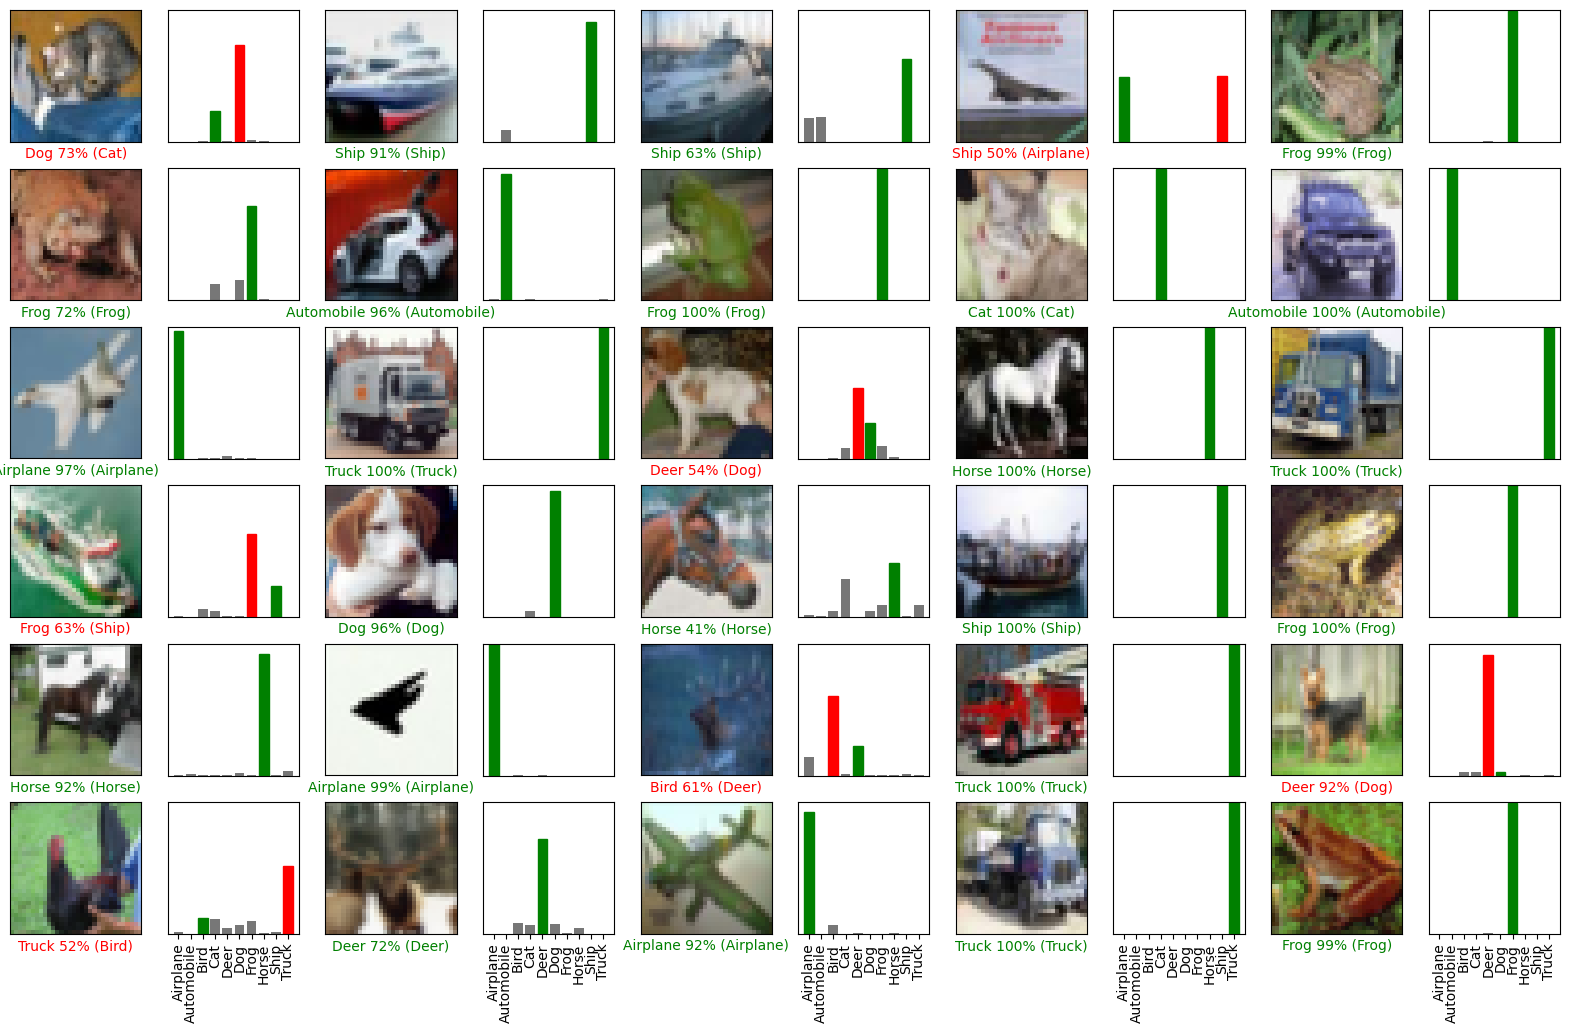

In [38]:
# verification of several images

num_rows=6
num_cols=5
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))

show_x_ticks = False

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)

    plot_image(i, predictions, y_test, x_test, class_names)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, y_test, class_names,show_x_ticks)

plt.show()


In [39]:
for i in range(len(cnn_model.layers)):
    layer = cnn_model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i , layer.name , layer.output.shape)



0 conv2d_4 (None, 32, 32, 16)
1 conv2d_5 (None, 32, 32, 16)
4 conv2d_6 (None, 16, 16, 48)
5 conv2d_7 (None, 16, 16, 48)
8 conv2d_8 (None, 8, 8, 16)
9 conv2d_9 (None, 8, 8, 16)


In [40]:
# redefine model to output right after the first hidden layer
model_tmp = Model(inputs=cnn_model.inputs, outputs=cnn_model.layers[1].output)

In [41]:
img = np.expand_dims(x_test[0], axis=0)

1/1 [==============================] - 0s 180ms/step


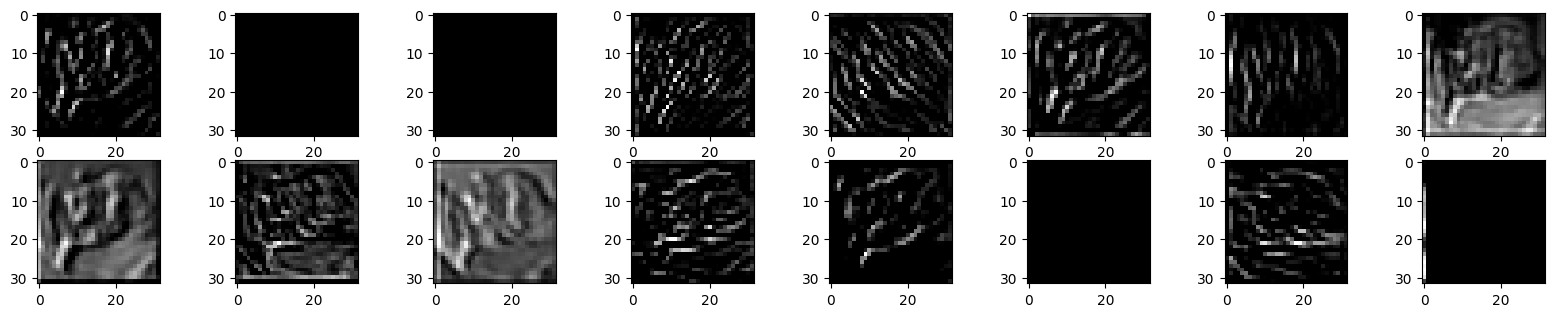

In [42]:
#calculating features_map
features = model_tmp.predict(img)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')

plt.show()



In [43]:
layers = [ 0, 1 , 4 , 5 , 8, 9]
outputs = [cnn_model.layers[i].output for i in layers]

model_tmp2 = Model( inputs= cnn_model.inputs, outputs = outputs)

1/1 [==============================] - 0s 364ms/step


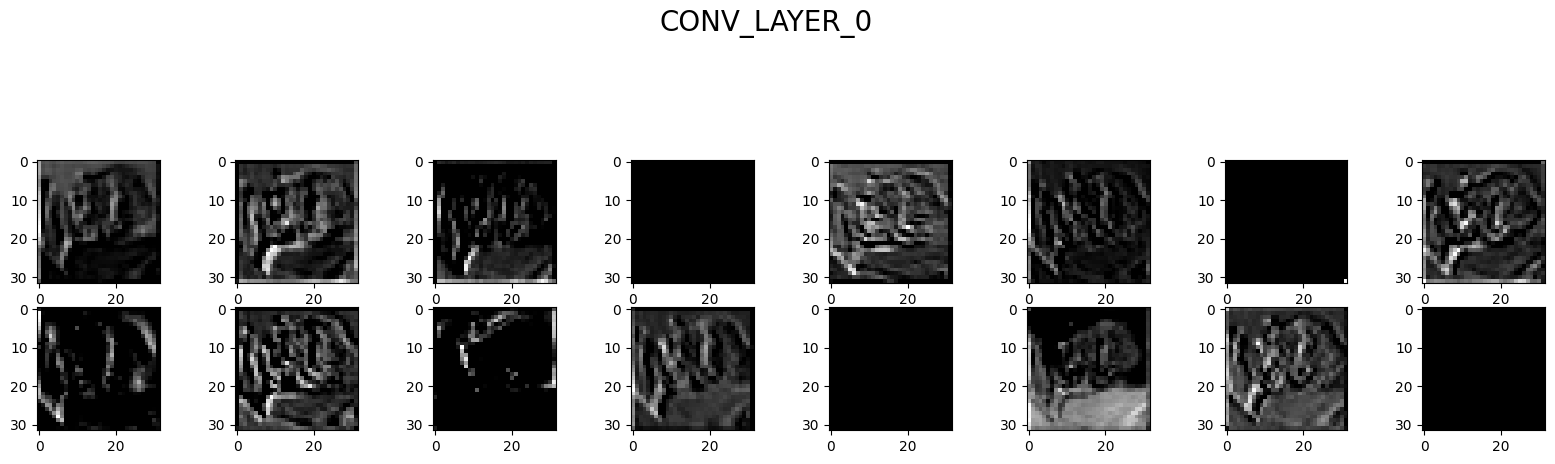

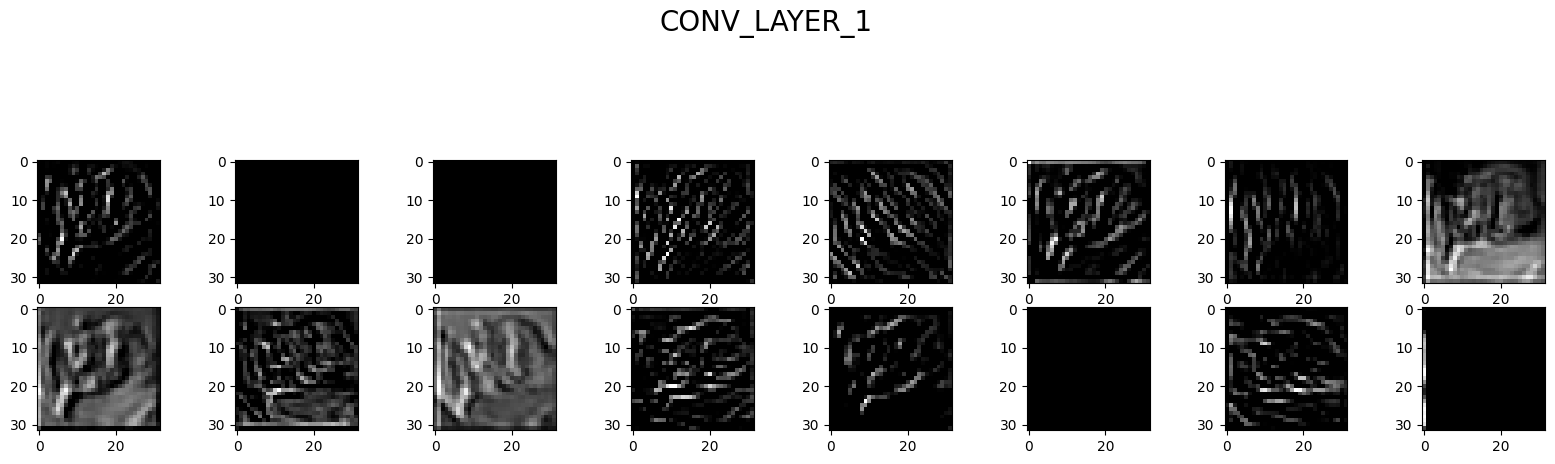

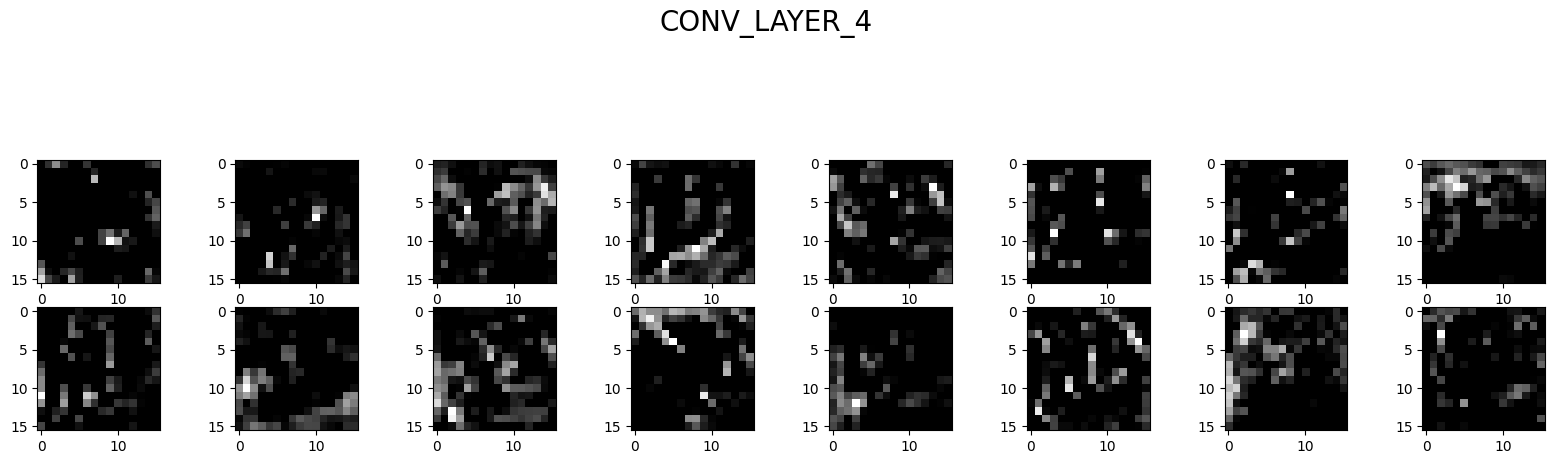

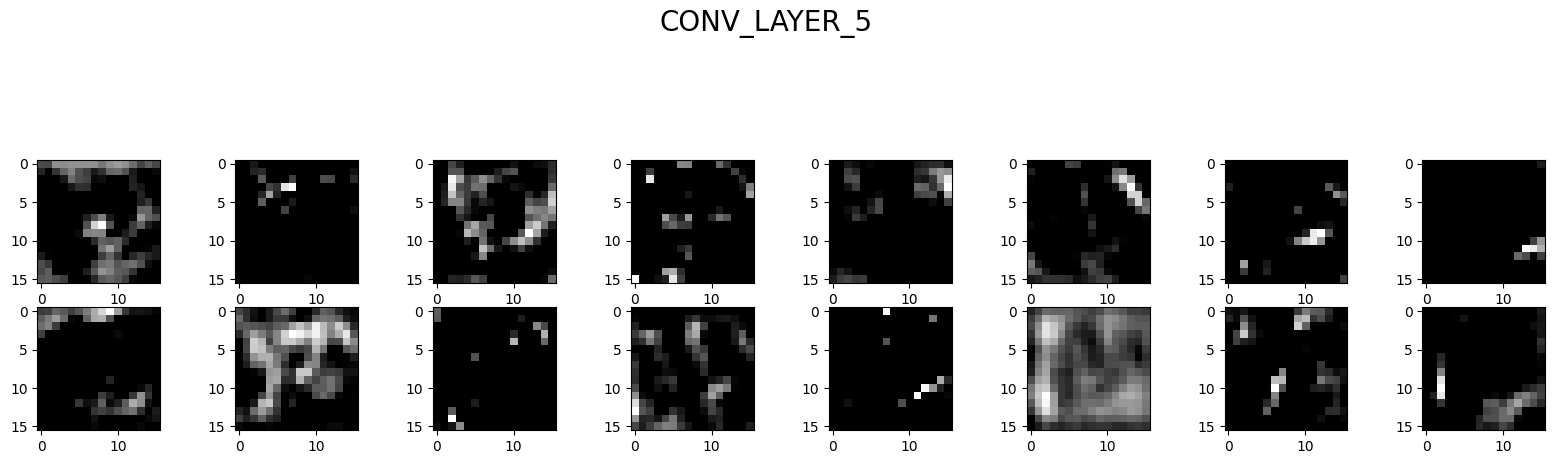

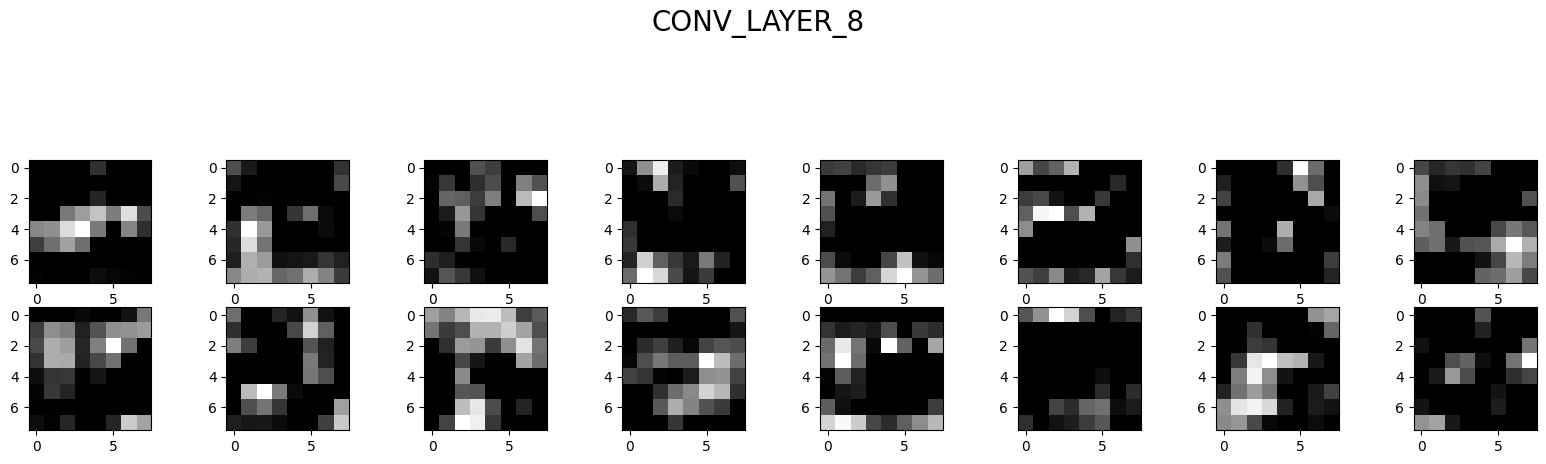

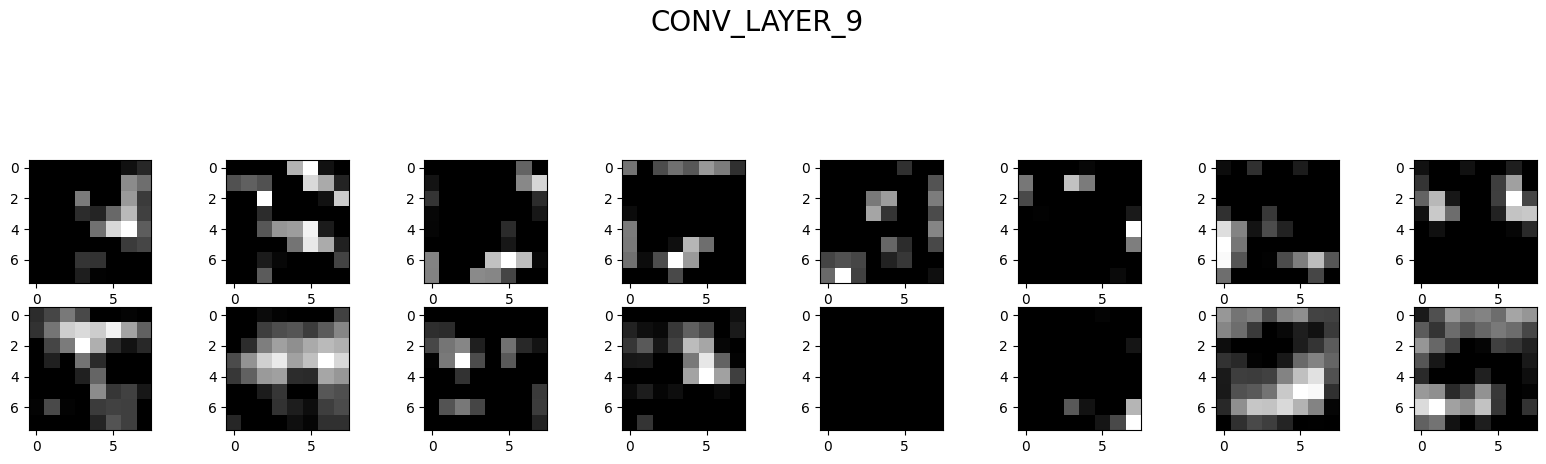

In [44]:
feature_map = model_tmp2.predict(img)

for i,fmap in zip(layers,feature_map):
    fig = plt.figure(figsize=(20,15))
    #https://stackoverflow.com/a/12444777
    fig.suptitle("CONV_LAYER_{}".format(i) , fontsize=20)
    for i in range(1,features.shape[3]+1):

        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1] , cmap='gray')

plt.show()

In [45]:
# Fit with data augmentation
# Note: if you run this AFTER calling
# the previous model.fit()
# it will CONTINUE training where it left off
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = data_generator.flow(
    x_train,
    y_train,
    batch_size,
    subset='training')


validation_generator = data_generator.flow(
    x_train,
    y_train,
    batch_size,
    subset='validation')
# set as validation data

# steps_per_epoch = x_train.shape[0] // batch_size

r = cnn_model.fit(train_generator, validation_data=validation_generator,
                #   steps_per_epoch=steps_per_epoch,
                  epochs=50, callbacks=[early_stopping])


1250/1250 [==============================] - 34s 27ms/step - loss: 0.7662 - accuracy: 0.7352 - val_loss: 0.7388 - val_accuracy: 0.7437
Epoch 2/50
1250/1250 [==============================] - 32s 26ms/step - loss: 0.6816 - accuracy: 0.7650 - val_loss: 0.8628 - val_accuracy: 0.7092
Epoch 3/50
1250/1250 [==============================] - 33s 27ms/step - loss: 0.6444 - accuracy: 0.7750 - val_loss: 0.6826 - val_accuracy: 0.7614
Epoch 4/50
1250/1250 [==============================] - 33s 27ms/step - loss: 0.6185 - accuracy: 0.7878 - val_loss: 0.8233 - val_accuracy: 0.7189
Epoch 5/50
1250/1250 [==============================] - 33s 26ms/step - loss: 0.5941 - accuracy: 0.7934 - val_loss: 0.7149 - val_accuracy: 0.7588
Epoch 6/50
1250/1250 [==============================] - 37s 30ms/step - loss: 0.5720 - accuracy: 0.8012 - val_loss: 0.6081 - val_accuracy: 0.7923
Epoch 7/50
1250/1250 [==============================] - 33s 27ms/step - loss: 0.5553 - accuracy: 0.8078 - val_loss: 0.6510 - val_accura

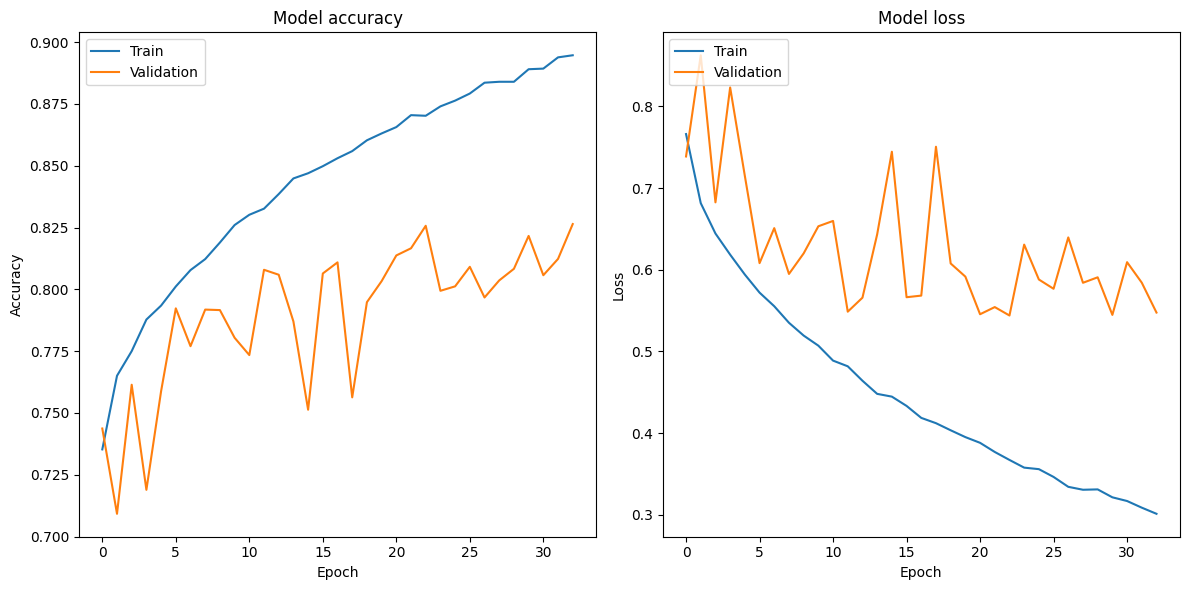

In [47]:
plot_training_curves(r)

In [49]:
# test the model on testing data
eval_result = cnn_model.evaluate(x_test, y_test, verbose = 1)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 2s 6ms/step - loss: 0.5821 - accuracy: 0.8249
[test loss, test accuracy]: [0.5820972323417664, 0.8248999714851379]


In [48]:
# predictions = np.argmax(model.predict(X_test), -1)
predictions = cnn_model.predict(x_test)
print(classification_report(y_test, np.argmax(predictions,-1), target_names=class_names))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    Airplane       0.84      0.87      0.85      1000
  Automobile       0.93      0.89      0.91      1000
        Bird       0.86      0.68      0.76      1000
         Cat       0.76      0.55      0.64      1000
        Deer       0.83      0.83      0.83      1000
         Dog       0.71      0.79      0.75      1000
        Frog       0.77      0.91      0.84      1000
       Horse       0.88      0.88      0.88      1000
        Ship       0.92      0.90      0.91      1000
       Truck       0.78      0.95      0.86      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



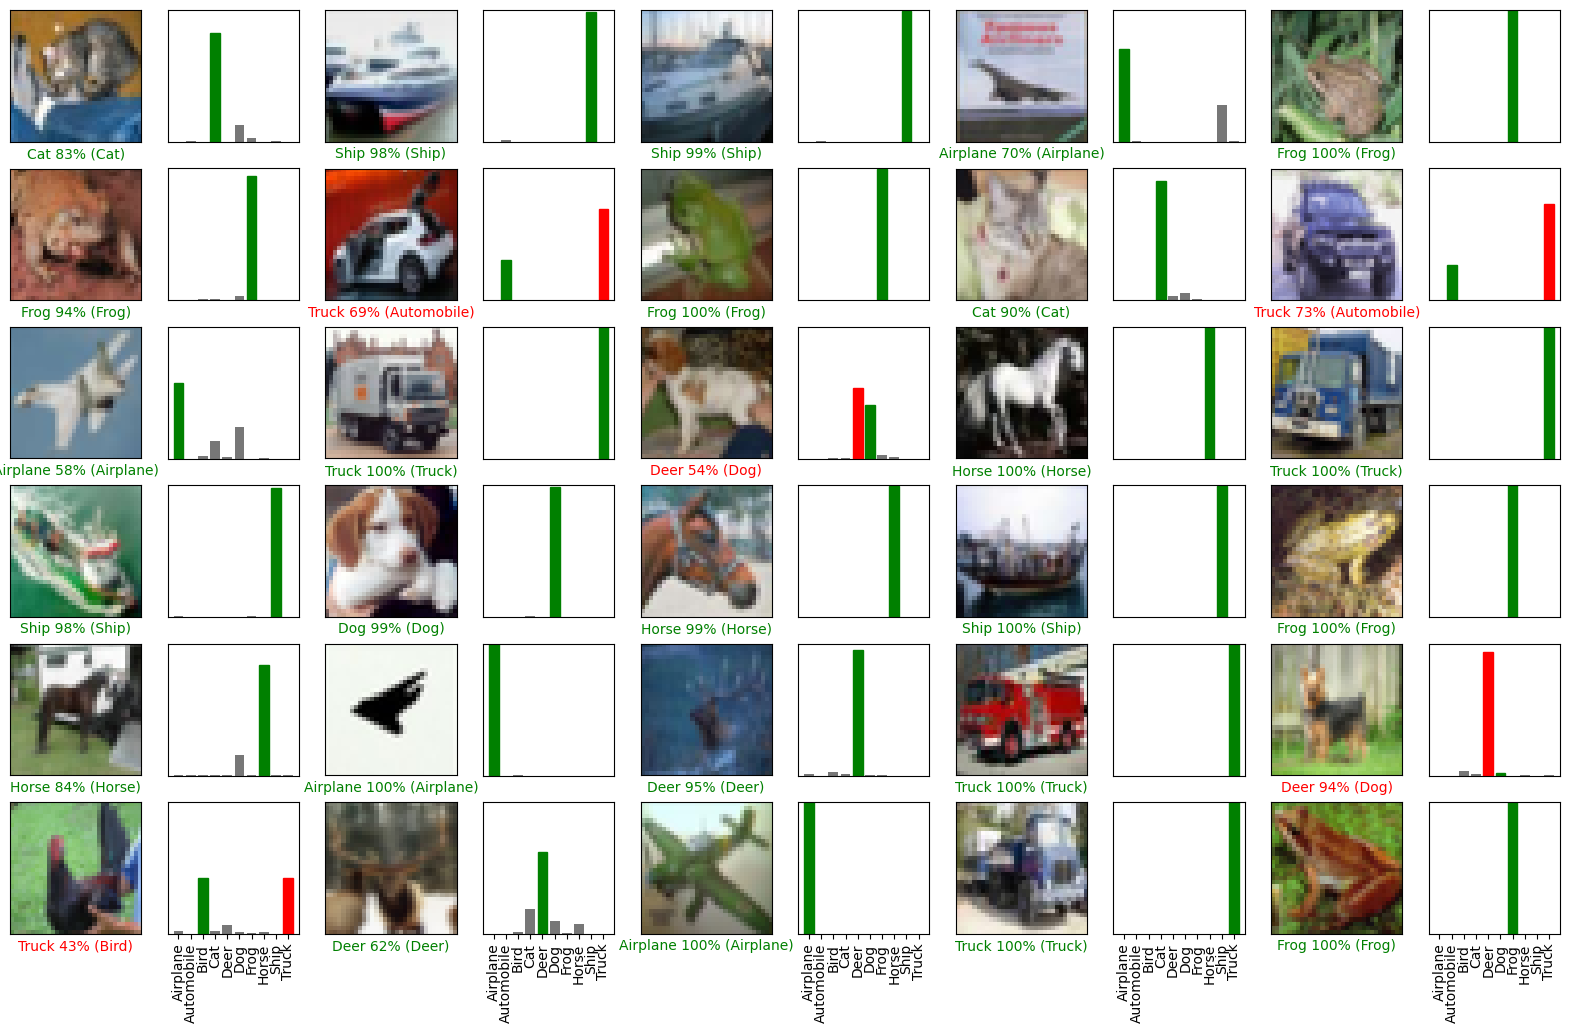

In [50]:
# verification of several images

num_rows=6
num_cols=5
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))

show_x_ticks = False

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)

    plot_image(i, predictions, y_test, x_test, class_names)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, y_test, class_names,show_x_ticks)

plt.show()
